In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SELECTED_SPPNAMES = [
    "MASSENGL_G8",
    "AEEC",
    "PALE_ESS_EN",
    "LONEWOLF_ALL",
    "PALMWI_UNIT1",
    "CAMWIND_RN",
    "PYR_PYRON1",
    "TKWSW_CHAMP",
    "TKWSW_ROSCOE",
    "IND_INADALE1",
    "ASTRA_RN",
    "HRFDWIND_ALL",
    "MARIAH_ALL",
    "SSPURT_WIND1",
    "CN_BRKS_UNT1",
    "FRYE_SLR_ALL",
    "MWEC_G1",
    "CFLATS_UNIT",
    "COTPLNS_RN",
    "SPLAIN1_RN",
]

In [3]:
df_results = pd.concat(list(map(
    lambda sppname: pd.read_csv(f'../results/all_nodes/csv/{sppname}_results.csv'),
    SELECTED_SPPNAMES
)))

In [4]:
df_results["cost"] = df_results["SPP_DA"]*df_results["awarded"]
df_results["profit_perc"] = df_results["profit"] / df_results["cost"]
# Cuando el costo es 0, el profit_perc es 0
df_results.loc[df_results["cost"] == 0, "profit_perc"] = 0

In [5]:
df_by_sppname = df_results.pivot(index='date', columns='settlementPoint', values='profit')
# Cummulative profit for all spp
df_by_sppname_cum = df_by_sppname.cumsum()
# Percentage return for all spp, return /
df_by_sppname_perc_ret = df_results.pivot(index='date', columns='settlementPoint', values='profit_perc')

In [6]:
df_by_sppname.index = pd.to_datetime(df_by_sppname.index)
df_by_sppname_cum.index = pd.to_datetime(df_by_sppname_cum.index)
df_by_sppname_perc_ret.index = pd.to_datetime(df_by_sppname_perc_ret.index)

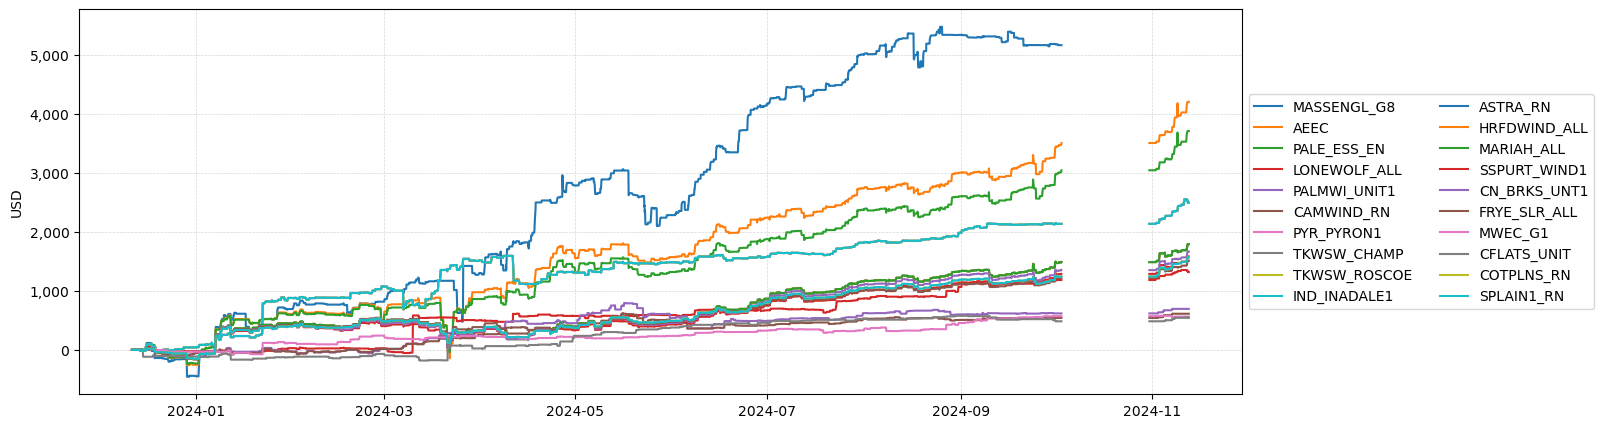

In [7]:
#df_by_sppname.plot(figsize=(15, 5))

_, ax = plt.subplots(figsize=(15, 5))

for sppname in SELECTED_SPPNAMES:
    ax.plot(df_by_sppname_cum.index, df_by_sppname_cum[sppname], label=sppname)

# grid
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5)
# legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
# Thousands separator for y-axis
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('USD')
plt.show()

### Markowitz optimization

### Monte Carlo simulation

In [8]:
n = 50_000

weights = np.zeros(shape=(n, len(SELECTED_SPPNAMES)))
volatility = np.zeros(n)
sharpe_ratio = np.zeros(n)
returns = np.zeros(n)

for i in range(n):
    # Random normalized weights
    w = np.array(np.random.random(len(SELECTED_SPPNAMES)))
    w = w / np.sum(w)
    # Save weights
    weights[i, :] = w
    returns[i] = df_by_sppname_perc_ret.mean().values @ w
    # Expected volatility
    volatility[i] = np.sqrt(np.dot(w.T, np.dot(df_by_sppname_perc_ret.cov(), w)))
    # Sharpe ratio
    sharpe_ratio[i] = returns[i] / volatility[i]

In [9]:
max_sharpe_ratio_idx = sharpe_ratio.argmax()
max_sharpe_ratio = sharpe_ratio[max_sharpe_ratio_idx]

max_sr_returns = returns[max_sharpe_ratio_idx]
max_sr_volatility = volatility[max_sharpe_ratio_idx]

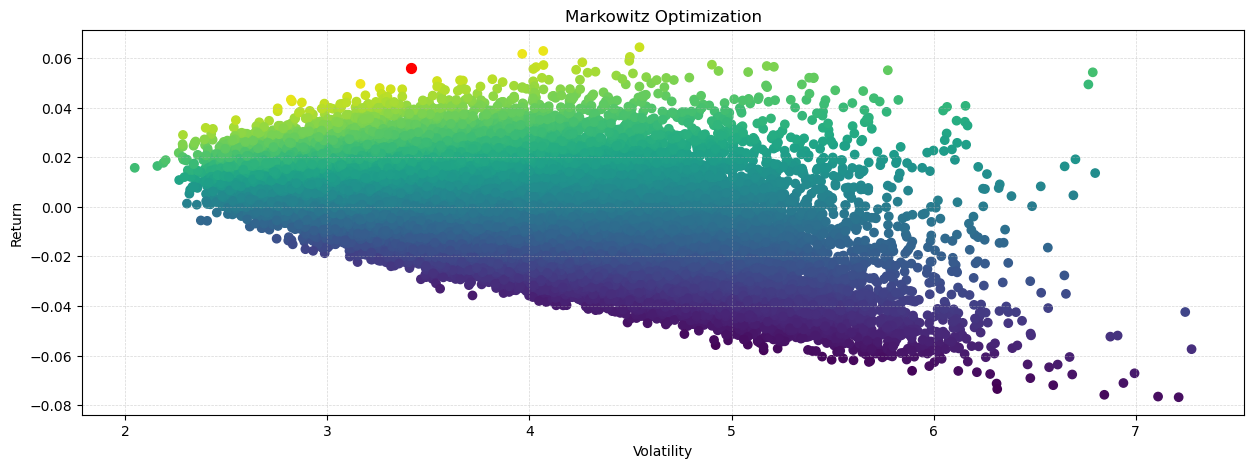

In [10]:
_, ax = plt.subplots(figsize=(15, 5))

ax.scatter(volatility, returns, c=sharpe_ratio, cmap='viridis')
ax.scatter(max_sr_volatility, max_sr_returns, c='red', s=50) # red dot

ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.set_title('Markowitz Optimization')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [11]:
# Cummulative weighthed profit
df_by_sppname_cum['portfolio'] = df_by_sppname.values @ weights[max_sharpe_ratio_idx]
df_by_sppname_cum['portfolio'] = df_by_sppname_cum['portfolio'].cumsum()

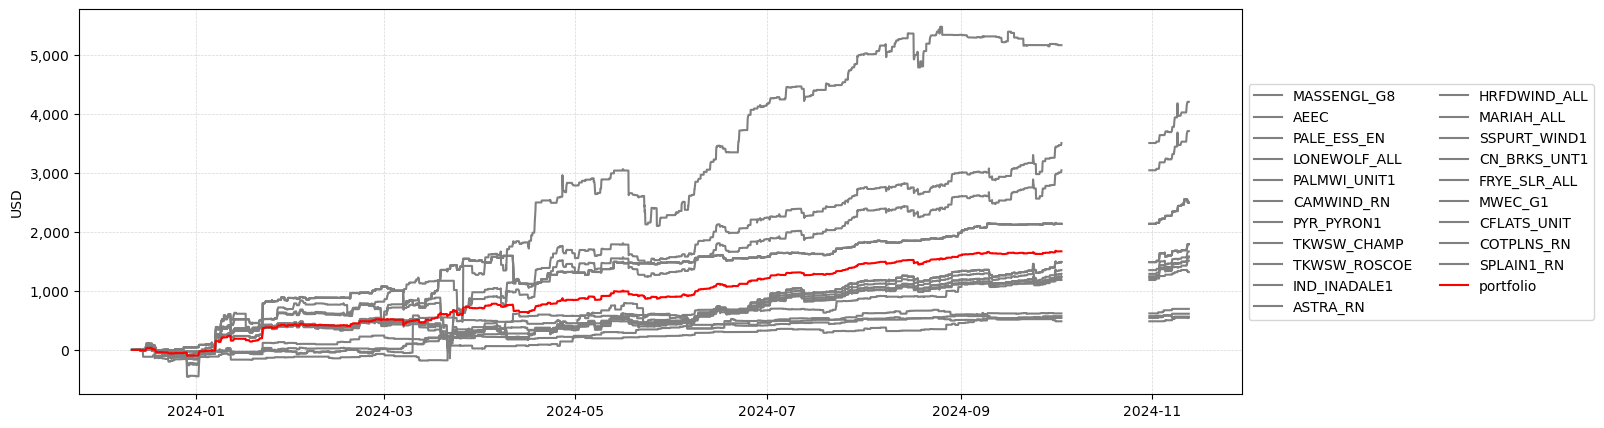

In [12]:
_, ax = plt.subplots(figsize=(15, 5))

for sppname in SELECTED_SPPNAMES + ['portfolio']:
    # all gray and portfolio red
    color = 'red' if sppname == 'portfolio' else 'gray'
    ax.plot(df_by_sppname_cum.index, df_by_sppname_cum[sppname], label=sppname, color=color)

# grid
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5)
# legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
# Thousands separator for y-axis
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('USD')
plt.show()

In [13]:
list(zip(list(df_by_sppname.columns), (weights[max_sharpe_ratio_idx]*100).round(2)))

[('AEEC', 0.47),
 ('ASTRA_RN', 1.52),
 ('CAMWIND_RN', 9.1),
 ('CFLATS_UNIT', 9.59),
 ('CN_BRKS_UNT1', 6.23),
 ('COTPLNS_RN', 2.6),
 ('FRYE_SLR_ALL', 5.29),
 ('HRFDWIND_ALL', 1.28),
 ('IND_INADALE1', 5.81),
 ('LONEWOLF_ALL', 4.85),
 ('MARIAH_ALL', 0.22),
 ('MASSENGL_G8', 9.54),
 ('MWEC_G1', 9.93),
 ('PALE_ESS_EN', 0.09),
 ('PALMWI_UNIT1', 2.35),
 ('PYR_PYRON1', 4.19),
 ('SPLAIN1_RN', 1.24),
 ('SSPURT_WIND1', 8.22),
 ('TKWSW_CHAMP', 8.8),
 ('TKWSW_ROSCOE', 8.69)]

In [14]:
from scipy import optimize

In [15]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = df_by_sppname.mean().values @ weights
    vol = np.sqrt(np.dot(weights.T, np.dot(df_by_sppname.cov(), weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

In [16]:
cons = ({'type': 'eq', 'fun': check_sum})

In [17]:
bounds = tuple((0, 1) for sppname in SELECTED_SPPNAMES)

In [18]:
init_guess = [1/len(SELECTED_SPPNAMES) for sppname in SELECTED_SPPNAMES]

In [19]:
opt_results = optimize.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [20]:
for sppname, weight in zip(SELECTED_SPPNAMES, opt_results.x):
    print(f"{sppname}: {weight*100:.2f}%")

MASSENGL_G8: 15.75%
AEEC: 0.00%
PALE_ESS_EN: 18.71%
LONEWOLF_ALL: 11.80%
PALMWI_UNIT1: 0.00%
CAMWIND_RN: 2.36%
PYR_PYRON1: 1.82%
TKWSW_CHAMP: 0.00%
TKWSW_ROSCOE: 5.20%
IND_INADALE1: 12.79%
ASTRA_RN: 0.00%
HRFDWIND_ALL: 3.91%
MARIAH_ALL: 3.10%
SSPURT_WIND1: 0.00%
CN_BRKS_UNT1: 4.07%
FRYE_SLR_ALL: 5.85%
MWEC_G1: 2.36%
CFLATS_UNIT: 0.55%
COTPLNS_RN: 5.85%
SPLAIN1_RN: 5.85%


In [21]:
df_by_sppname_cum["portfolio"] = df_by_sppname.values @ opt_results.x
df_by_sppname_cum["portfolio"] = df_by_sppname_cum["portfolio"].cumsum()

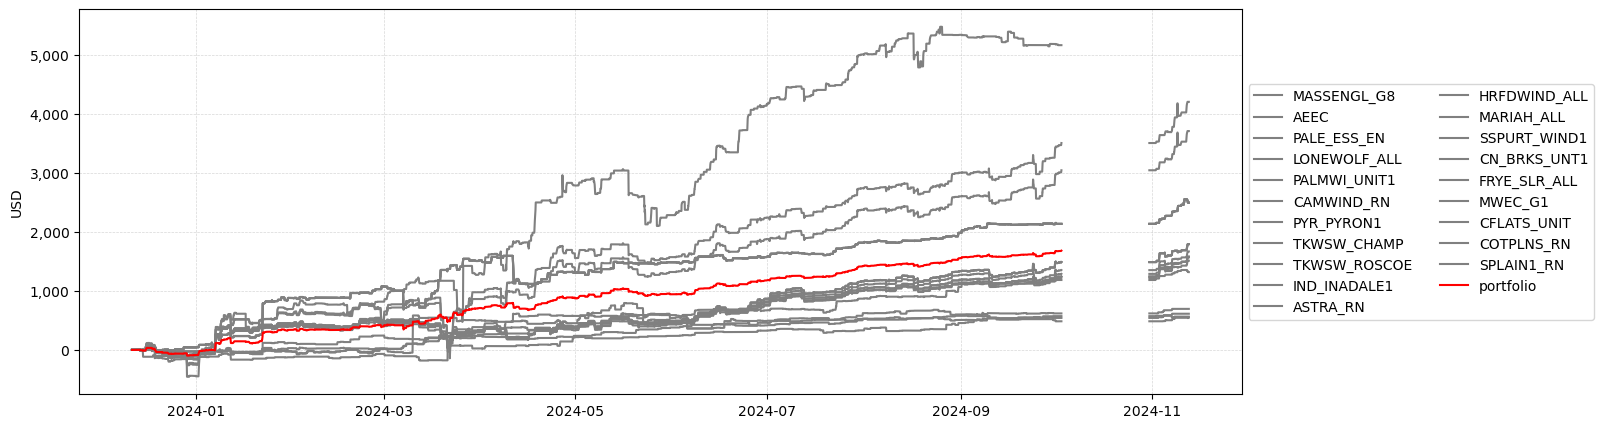

In [22]:
_, ax = plt.subplots(figsize=(15, 5))

for sppname in SELECTED_SPPNAMES + ['portfolio']:
    # all gray and portfolio red
    color = 'red' if sppname == 'portfolio' else 'gray'
    ax.plot(df_by_sppname_cum.index, df_by_sppname_cum[sppname], label=sppname, color=color)

# grid
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5)
# legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
# Thousands separator for y-axis
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('USD')
plt.show()

### Efficient Frontier

In [ ]:
frontier_y = np.linspace(returns.min(), returns.max(), 100)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': check_sum},
            {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = optimize.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun']*-1)

frontier_x = np.array(frontier_x)

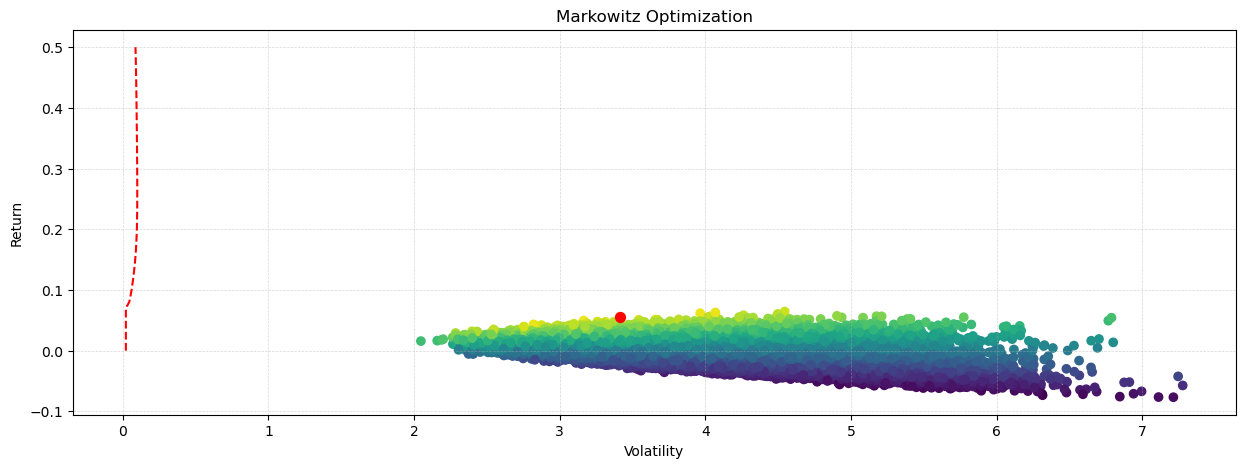

In [25]:
_, ax = plt.subplots(figsize=(15, 5))

ax.scatter(volatility, returns, c=sharpe_ratio, cmap='viridis')
ax.scatter(max_sr_volatility, max_sr_returns, c='red', s=50) # red dot
ax.plot(frontier_x, frontier_y, 'r--')

ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.set_title('Markowitz Optimization')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

array([-0.01497534, -0.02075579, -0.01573871, ..., -0.01131623,
       -0.00928588, -0.03175042])